# Loan and housing data —EDA, cleansing, and data imputation

---
por [<span style="font-family:monospace;">Andres Ethorimn</span>](https://www.linkedin.com/in/ethlob/) 👨🏾‍💻

<span style="color:green; font-weight:bold;">Staging:</span> en este notebook vamos a analizar los datos estructurados en el paso anterior y a tomar algunas decisiones con base al comportamiento de los mismos. Estas decisiones tendrán que ven con la imputación de sus valores, la creación de nuevas variables y la eliminación de aquellas que no aportan valor al análisis. Todo en el marco de un análisis exploratorio de datos (EDA, por sus siglas en inglés), y de los objetos analíticos del ejercicio.

<span style="font-size:small; color:gray;">*Los notebooks en esta sección son prototipos. Su uso es exclusivo para exploración y aprendizaje, y no están pensado para usarse en producción. Tenga presente que los comentarios del código en inglés por ser el idioma estándar de la industria.*</span>

In [29]:
# Import neccessary libraries
import os
import sys

# Adding the source code directory to the system path
source_dir = os.path.join(os.path.dirname(os.getcwd()), 'src')
sys.path.append(source_dir)

import warnings

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

from scipy.stats import shapiro, f_oneway

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    make_scorer,
    silhouette_score,
    davies_bouldin_score,
)

from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.discretisation import EqualFrequencyDiscretiser
from feature_engine.transformation import YeoJohnsonTransformer
from feature_engine.encoding import (
    OneHotEncoder, 
    OrdinalEncoder, 
    CountFrequencyEncoder,
)
from feature_engine.imputation import (
    CategoricalImputer, 
    MeanMedianImputer
)
from feature_engine.selection import (
    DropConstantFeatures, 
    DropDuplicateFeatures,
    DropCorrelatedFeatures,
)

# Import custom modules from source directory
from features.SklearnEstimator import StringDictionaryMapper
from utils.dataHistVisualization import visualize_histograms
from utils.saveModel import save_model

In [2]:
# Define data directory
parent_dir = os.path.dirname(os.getcwd())
data_dir = os.path.join(parent_dir, 'data')

In [3]:
# Set random state for further implementations
random_state = 11

In [4]:
# Load the data from the Excel file in staging directory
data = pd.read_excel(os.path.join(data_dir, 'staging', '01_data_prueba_ds_loan_housing_basic_schema.xlsx'), engine='openpyxl', index_col=0)

In [5]:
# Vamos a visualizar características básicas de los datos cargados desde la fuente estructurada
print('<---- Basic data description ---->')
display(data.describe())
print('\n')
print('<---- Basic data info ---->')
display(data.info())

<---- Basic data description ---->


,age,default,balance,housing,loan,duration,campaign,pdays,previous,deposit,...,ingresos,egresos,saldo_captacion,saldo_tdc,monto_trx_tdc,cantidad_trx_tdc,saldo_lb,saldo_veh,monto_trx_debito,cantidad_trx_debito
count,11162.000000,11162.000000,8884.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,11162.000000,...,8950.000000,8896.000000,7972.000000,8016.000000,7983.000000,7980.000000,3357.000000,2238.000000,7279.000000,7275.000000
mean,41.231948,0.015051,1585.878558,0.473123,0.130801,401.981720,2.508421,51.330407,0.832557,0.473840,...,2480.927582,2254.691972,10530.469385,8035.747659,1214.676085,20.005482,30385.703271,60792.063849,3009.643796,20.132298
std,11.913369,0.121761,3313.185954,0.499299,0.337198,347.280631,2.722077,108.758282,2.292007,0.499338,...,1588.880494,1575.013127,4007.126805,6033.023165,996.186860,15.031332,14982.656745,28029.765769,1997.271643,14.974287
min,18.000000,0.000000,-6805.221395,0.000000,0.000000,-1.353598,1.000000,-1.000000,0.000000,0.000000,...,-3090.885131,-2506.104373,-2687.247223,-11769.150440,-2456.440099,-43.497472,-17300.361753,-28294.008605,-3589.716813,-34.846601
25%,32.000000,0.000000,172.321525,0.000000,0.000000,168.976855,1.000000,-1.000000,0.000000,0.000000,...,1394.059413,1152.968416,7824.681827,4003.590138,532.191433,10.117232,20345.487496,42240.956708,1662.963847,10.016728
50%,39.000000,0.000000,604.052362,0.000000,0.000000,286.480152,2.000000,-1.000000,0.000000,0.000000,...,2184.790669,2116.438560,10551.903937,8030.458153,1226.634742,19.994614,30389.999913,60876.765020,3034.719315,20.258919
75%,49.000000,0.000000,1772.260058,1.000000,0.000000,526.382523,3.000000,20.750000,1.000000,1.000000,...,3364.989852,3267.768734,13166.739198,11996.450428,1890.894042,29.996303,40493.833423,80033.606630,4322.363760,30.331647
max,95.000000,1.000000,81269.474223,1.000000,1.000000,3892.988687,63.000000,854.000000,58.000000,1.000000,...,13546.541070,9078.899129,26637.625667,32161.094267,5368.117678,74.896488,89379.040561,170840.875713,11053.698089,82.521765




<---- Basic data info ---->
<class 'pandas.core.frame.DataFrame'>
Index: 11162 entries, 255 to 10927
Data columns (total 31 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  11162 non-null  int64  
 1   job                  11162 non-null  object 
 2   marital              8867 non-null   object 
 3   education            8925 non-null   object 
 4   default              11162 non-null  int64  
 5   balance              8884 non-null   float64
 6   housing              11162 non-null  int64  
 7   loan                 11162 non-null  int64  
 8   contact              11162 non-null  object 
 9   duration             11162 non-null  float64
 10  campaign             11162 non-null  int64  
 11  pdays                11162 non-null  int64  
 12  previous             11162 non-null  int64  
 13  poutcome             11162 non-null  object 
 14  deposit              11162 non-null  int64  
 15  tenencia_

None

👁️ <span style="color:steelblue; font-weight:bold;">Insight:</span> The value of the variable `pdays` represents the "Número de días desde último contacto en anteriores campañas comerciales". Let's observe the behavior of this variable, since it has a value of -1 for those clients who have not been previously contacted.

<Axes: >

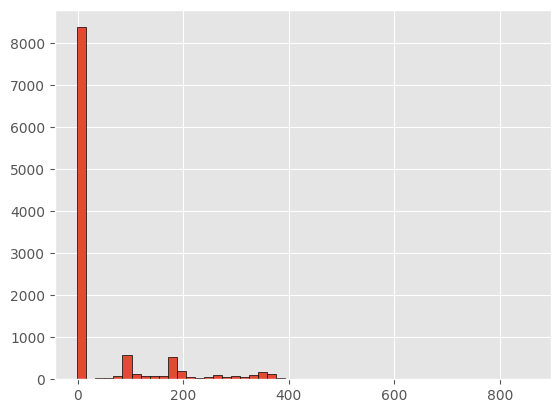

In [6]:
# Visualize the distribution of the 'pdays' column
data.pdays.hist(bins=50, edgecolor='black')

Observamos que, en efecto, en la variable `pdays` predomina el valor de -1 para aquellos clientes que no han sido contactados previamente. Esto es importante porque conlcuimos que la mayoría de los clientes no han sido contactados nunca. Esto puede ser útil para focalizar el target de estrategias de marketing y ventas, así como para identificar oportunidades de mejora en la comunicación con estos individuos. Vamos a extraer esta información para usarla en el futuro.

In [7]:
# Extract the 'pdays' column and create a new DataFrame to analyze if clients have been contacted
data_contacted = data.pop('pdays').to_frame()
data_contacted['been_contacted'] = data_contacted.pdays.apply(lambda value: True if value >= 0 else False)

👁️ <span style="color:steelblue; font-weight:bold;">Insight:</span> vamos a extraer también las variables objetivo, y las vamos a reintegrar con la versión procesada de nuestras características! Ya que las variables `loan` y `housing` son ambas categóricas y binarias, podemos construir una nueva variable objetivo: `target`, que integre las posibles combinaciones de estados en ambas, a saber:

- $0$: neither loan nor housing 😶‍🌫️
- $1$: loan but no housing 💵
- $2$: housing but no loan 🏠
- $3$: both loan and housing 🏠💵

In [8]:
data_target = data.loc[:, ['loan', 'housing']].copy()
data_target.loc[:, 'target'] = (
    data_target.apply(
        lambda col: 0 if (col.loan == 0 and col.housing == 0) else 1 if (col.loan == 1 and col.housing == 0) else 2 if (col.loan == 0 and col.housing == 1) else 3, 
        axis=1
))

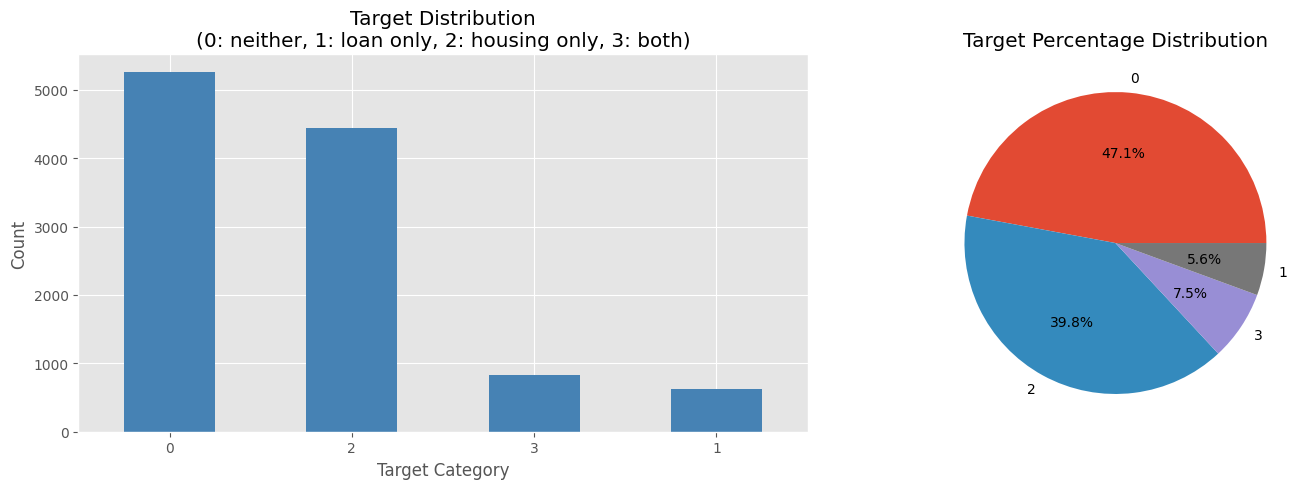

Target Distribution:
Target 0 (Neither loan nor housing): 5256 (47.1%)
Target 1 (Loan only): 625 (5.6%)
Target 2 (Housing only): 4446 (39.8%)
Target 3 (Both loan and housing): 835 (7.5%)


In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Absolute distribution
data_target['target'].value_counts().plot(kind='bar', ax=axes[0], color='steelblue')
axes[0].set_title('Target Distribution\n(0: neither, 1: loan only, 2: housing only, 3: both)')
axes[0].set_xlabel('Target Category')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x', rotation=0)

# Percentage distribution
data_target['target'].value_counts(normalize=True).plot(kind='pie', ax=axes[1], autopct='%1.1f%%')
axes[1].set_title('Target Percentage Distribution')
axes[1].set_ylabel('')

plt.tight_layout()
plt.show()

# Descriptive statistics by target
print("Target Distribution:")
target_stats = data_target['target'].value_counts().sort_index()
for i, count in target_stats.items():
    labels = {0: "Neither loan nor housing", 1: "Loan only", 2: "Housing only", 3: "Both loan and housing"}
    print(f"Target {i} ({labels[i]}): {count} ({count/len(data_target)*100:.1f}%)")

In [ ]:
# Analysis of numeric variables vs target
numeric_vars = [
    'age', 'balance', 'duration', 'campaign', 'previous', 'ingresos', 'egresos', 'saldo_captacion', 'saldo_tdc',
    'monto_trx_tdc', 'cantidad_trx_tdc', 'saldo_lb', 'saldo_veh', 'monto_trx_debito', 'cantidad_trx_debito'
]

# Create a combined DataFrame for analysis
data_analysis = data.copy()
data_analysis.loc[:, 'target'] = data_target.target

# Statistical analysis: ANOVA for numeric variables vs target
print("ANOVA Test Results (p-values) - Numeric variables vs Target:")
print("=" * 60)
anova_results = {}

for var in numeric_vars:
    if var in data_analysis.columns:
        # Remove null values for analysis
        clean_data = data_analysis[[var, 'target']].dropna()
        
        # Separate by target groups
        groups = [clean_data[clean_data['target'] == i][var].values for i in range(4)]
        
        # Filter empty groups
        groups = [group for group in groups if len(group) > 0]
        
        if len(groups) > 1:
            f_stat, p_value = f_oneway(*groups)
            anova_results[var] = p_value
            significance = "***" if p_value < 0.001 else "**" if p_value < 0.01 else "*" if p_value < 0.05 else ""
            print(f"{var:25} | p-value: {p_value:.6f} {significance}")

print("\n* p < 0.05, ** p < 0.01, *** p < 0.001")

ANOVA Test Results (p-values) - Numeric variables vs Target:
age                       | p-value: 0.000000 ***
balance                   | p-value: 0.000000 ***
duration                  | p-value: 0.002777 **
campaign                  | p-value: 0.000637 ***
previous                  | p-value: 0.000102 ***
ingresos                  | p-value: 0.000000 ***
egresos                   | p-value: 0.000000 ***
saldo_captacion           | p-value: 0.415637 
saldo_tdc                 | p-value: 0.343376 
monto_trx_tdc             | p-value: 0.331337 
cantidad_trx_tdc          | p-value: 0.893160 
saldo_lb                  | p-value: 0.613724 
saldo_veh                 | p-value: 0.852012 
monto_trx_debito          | p-value: 0.209128 
cantidad_trx_debito       | p-value: 0.835780 

* p < 0.05, ** p < 0.01, *** p < 0.001


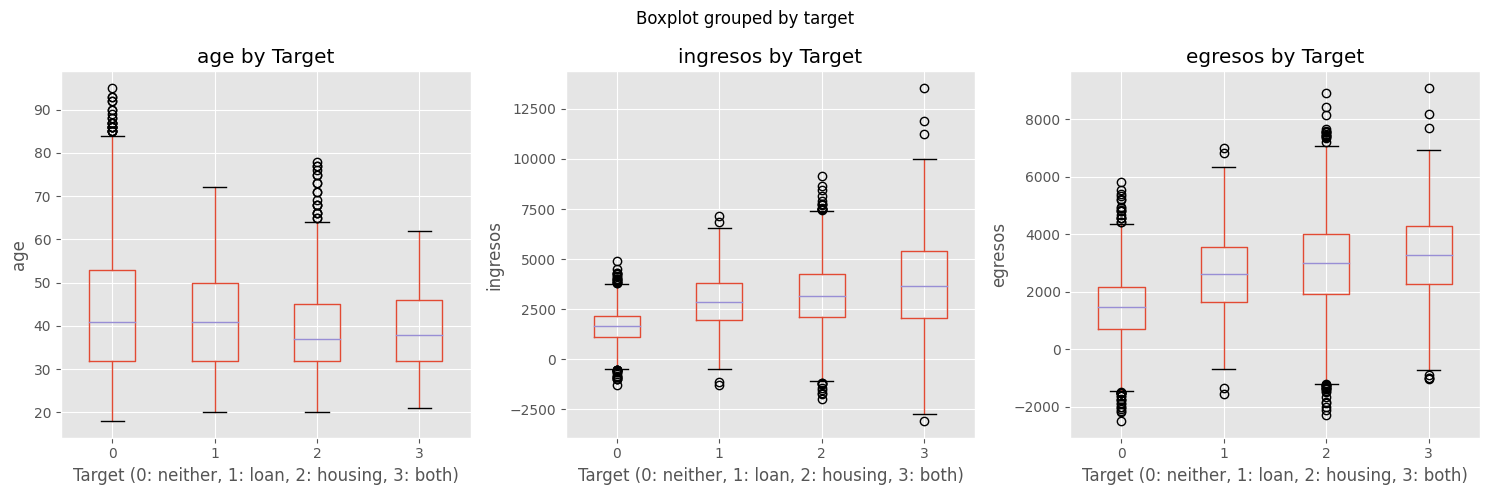

In [28]:
# Visualization of boxplots for most significant numeric variables
# significant_vars = [var for var, p_val in anova_results.items() if p_val < 0.05] # Some of those are not significant, so we filter them
significant_vars = ['age', 'ingresos', 'egresos']

if significant_vars:
    n_vars = len(significant_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    
    for i, var in enumerate(significant_vars):
        row = i // n_cols
        col = i % n_cols
        
        # Create boxplot
        data_analysis.boxplot(column=var, by='target', ax=axes[row, col])
        axes[row, col].set_title(f'{var} by Target')
        axes[row, col].set_xlabel('Target (0: neither, 1: loan, 2: housing, 3: both)')
        axes[row, col].set_ylabel(var)
    
    # Hide empty subplots
    for i in range(len(significant_vars), n_rows * n_cols):
        row = i // n_cols
        col = i % n_cols
        axes[row, col].set_visible(False)
    
    plt.tight_layout()
    plt.show()
else:
    print("No numeric variables significantly associated with target were found")

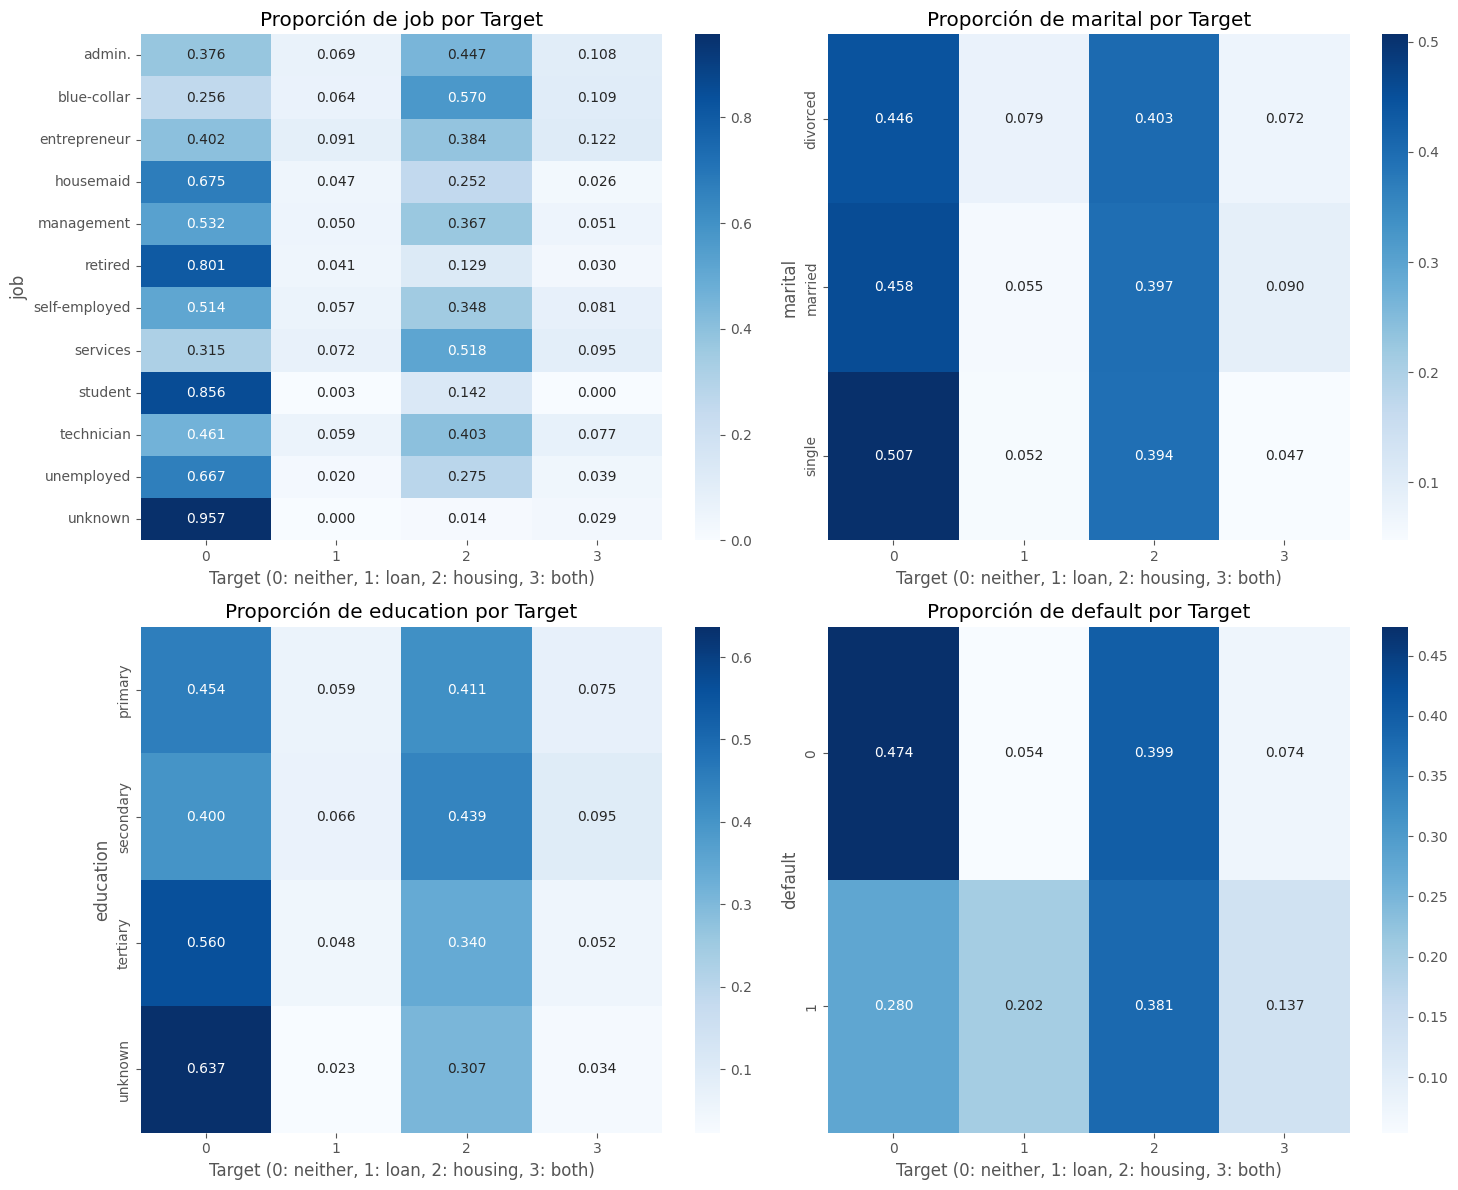

In [33]:
# Visualización de variables categóricas significativas
significant_cat_vars = ['job', 'marital', 'education', 'default']

n_vars = len(significant_cat_vars)
n_cols = 2
n_rows = (n_vars + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 6*n_rows))
if n_rows == 1:
    axes = axes.reshape(1, -1)

for i, var in enumerate(significant_cat_vars):
    row = i // n_cols
    col = i % n_cols
    
    # Crear tabla de contingencia normalizada
    cont_table = pd.crosstab(data_analysis[var], data_analysis['target'], normalize='index')
    
    # Crear heatmap
    sns.heatmap(cont_table, annot=True, fmt='.3f', cmap='Blues', ax=axes[row, col])
    axes[row, col].set_title(f'Proporción de {var} por Target')
    axes[row, col].set_xlabel('Target (0: neither, 1: loan, 2: housing, 3: both)')
    axes[row, col].set_ylabel(var)

# Ocultar subplots vacíos
for i in range(len(significant_cat_vars), n_rows * n_cols):
    row = i // n_cols
    col = i % n_cols
    axes[row, col].set_visible(False)

plt.tight_layout()
plt.show()

Correlaciones entre variables numéricas y target:
ingresos                  | Correlación:  0.4996
egresos                   | Correlación:  0.4815
age                       | Correlación: -0.1661
balance                   | Correlación: -0.0960
duration                  | Correlación:  0.0320
monto_trx_debito          | Correlación:  0.0190
saldo_lb                  | Correlación: -0.0187
campaign                  | Correlación:  0.0170
monto_trx_tdc             | Correlación:  0.0134
saldo_captacion           | Correlación:  0.0120
cantidad_trx_tdc          | Correlación: -0.0082
previous                  | Correlación: -0.0079
saldo_veh                 | Correlación: -0.0027
saldo_tdc                 | Correlación:  0.0025
cantidad_trx_debito       | Correlación:  0.0019


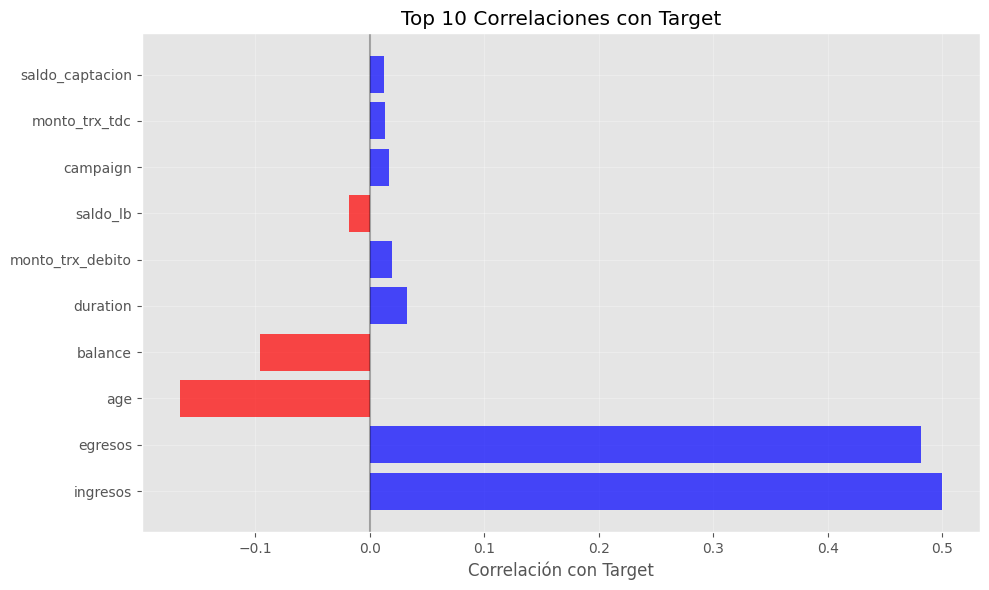

In [14]:
# Análisis de correlación entre variables numéricas y target
# Calcular correlaciones
target_correlations = data_analysis[numeric_vars + ['target']].corr()['target'].drop('target').sort_values(key=abs, ascending=False)

print("Correlaciones entre variables numéricas y target:")
print("=" * 50)
for var, corr in target_correlations.items():
    print(f"{var:25} | Correlación: {corr:7.4f}")

# Visualizar las correlaciones más altas
top_correlations = target_correlations.head(10)

plt.figure(figsize=(10, 6))
colors = ['red' if x < 0 else 'blue' for x in top_correlations.values]
plt.barh(range(len(top_correlations)), top_correlations.values, color=colors, alpha=0.7)
plt.yticks(range(len(top_correlations)), top_correlations.index)
plt.xlabel('Correlación con Target')
plt.title('Top 10 Correlaciones con Target')
plt.axvline(x=0, color='black', linestyle='-', alpha=0.3)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

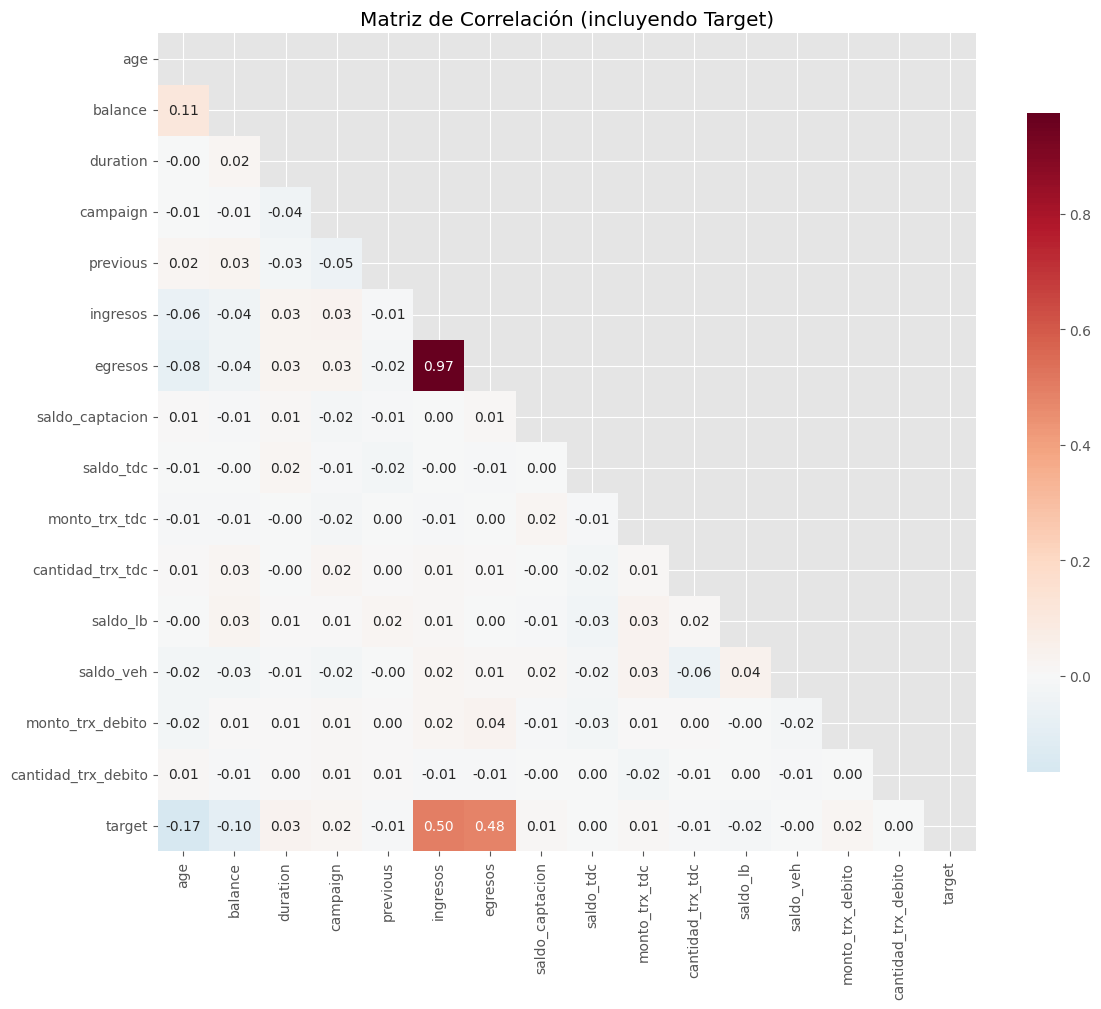


Top 10 correlaciones más fuertes con target (valor absoluto):
ingresos                  | |Correlación|: 0.4996
egresos                   | |Correlación|: 0.4815
age                       | |Correlación|: 0.1661
balance                   | |Correlación|: 0.0960
duration                  | |Correlación|: 0.0320
monto_trx_debito          | |Correlación|: 0.0190
saldo_lb                  | |Correlación|: 0.0187
campaign                  | |Correlación|: 0.0170
monto_trx_tdc             | |Correlación|: 0.0134
saldo_captacion           | |Correlación|: 0.0120


In [15]:
# Matriz de correlación general incluyendo target
# Seleccionar variables numéricas disponibles para correlación
available_numeric = [var for var in numeric_vars if var in data_analysis.columns]
correlation_vars = available_numeric + ['target']

correlation_matrix = data_analysis[correlation_vars].corr()

# Crear heatmap de correlación
plt.figure(figsize=(12, 10))
mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, 
            mask=mask,
            annot=True, 
            fmt='.2f', 
            cmap='RdBu_r', 
            center=0,
            square=True,
            cbar_kws={"shrink": .8})
plt.title('Matriz de Correlación (incluyendo Target)')
plt.tight_layout()
plt.show()

# Identificar las correlaciones más fuertes con el target
target_corr_abs = correlation_matrix['target'].abs().sort_values(ascending=False)
print("\nTop 10 correlaciones más fuertes con target (valor absoluto):")
for var, corr in target_corr_abs.head(11).items():  # 11 porque incluye la correlación consigo mismo
    if var != 'target':
        print(f"{var:25} | |Correlación|: {corr:.4f}")

Mencionar insgihts de las variables numéricas de acuerdo al análisis de su distribución y comportamiento.

In [16]:
data = data.drop(columns=['loan', 'housing'], axis=1)

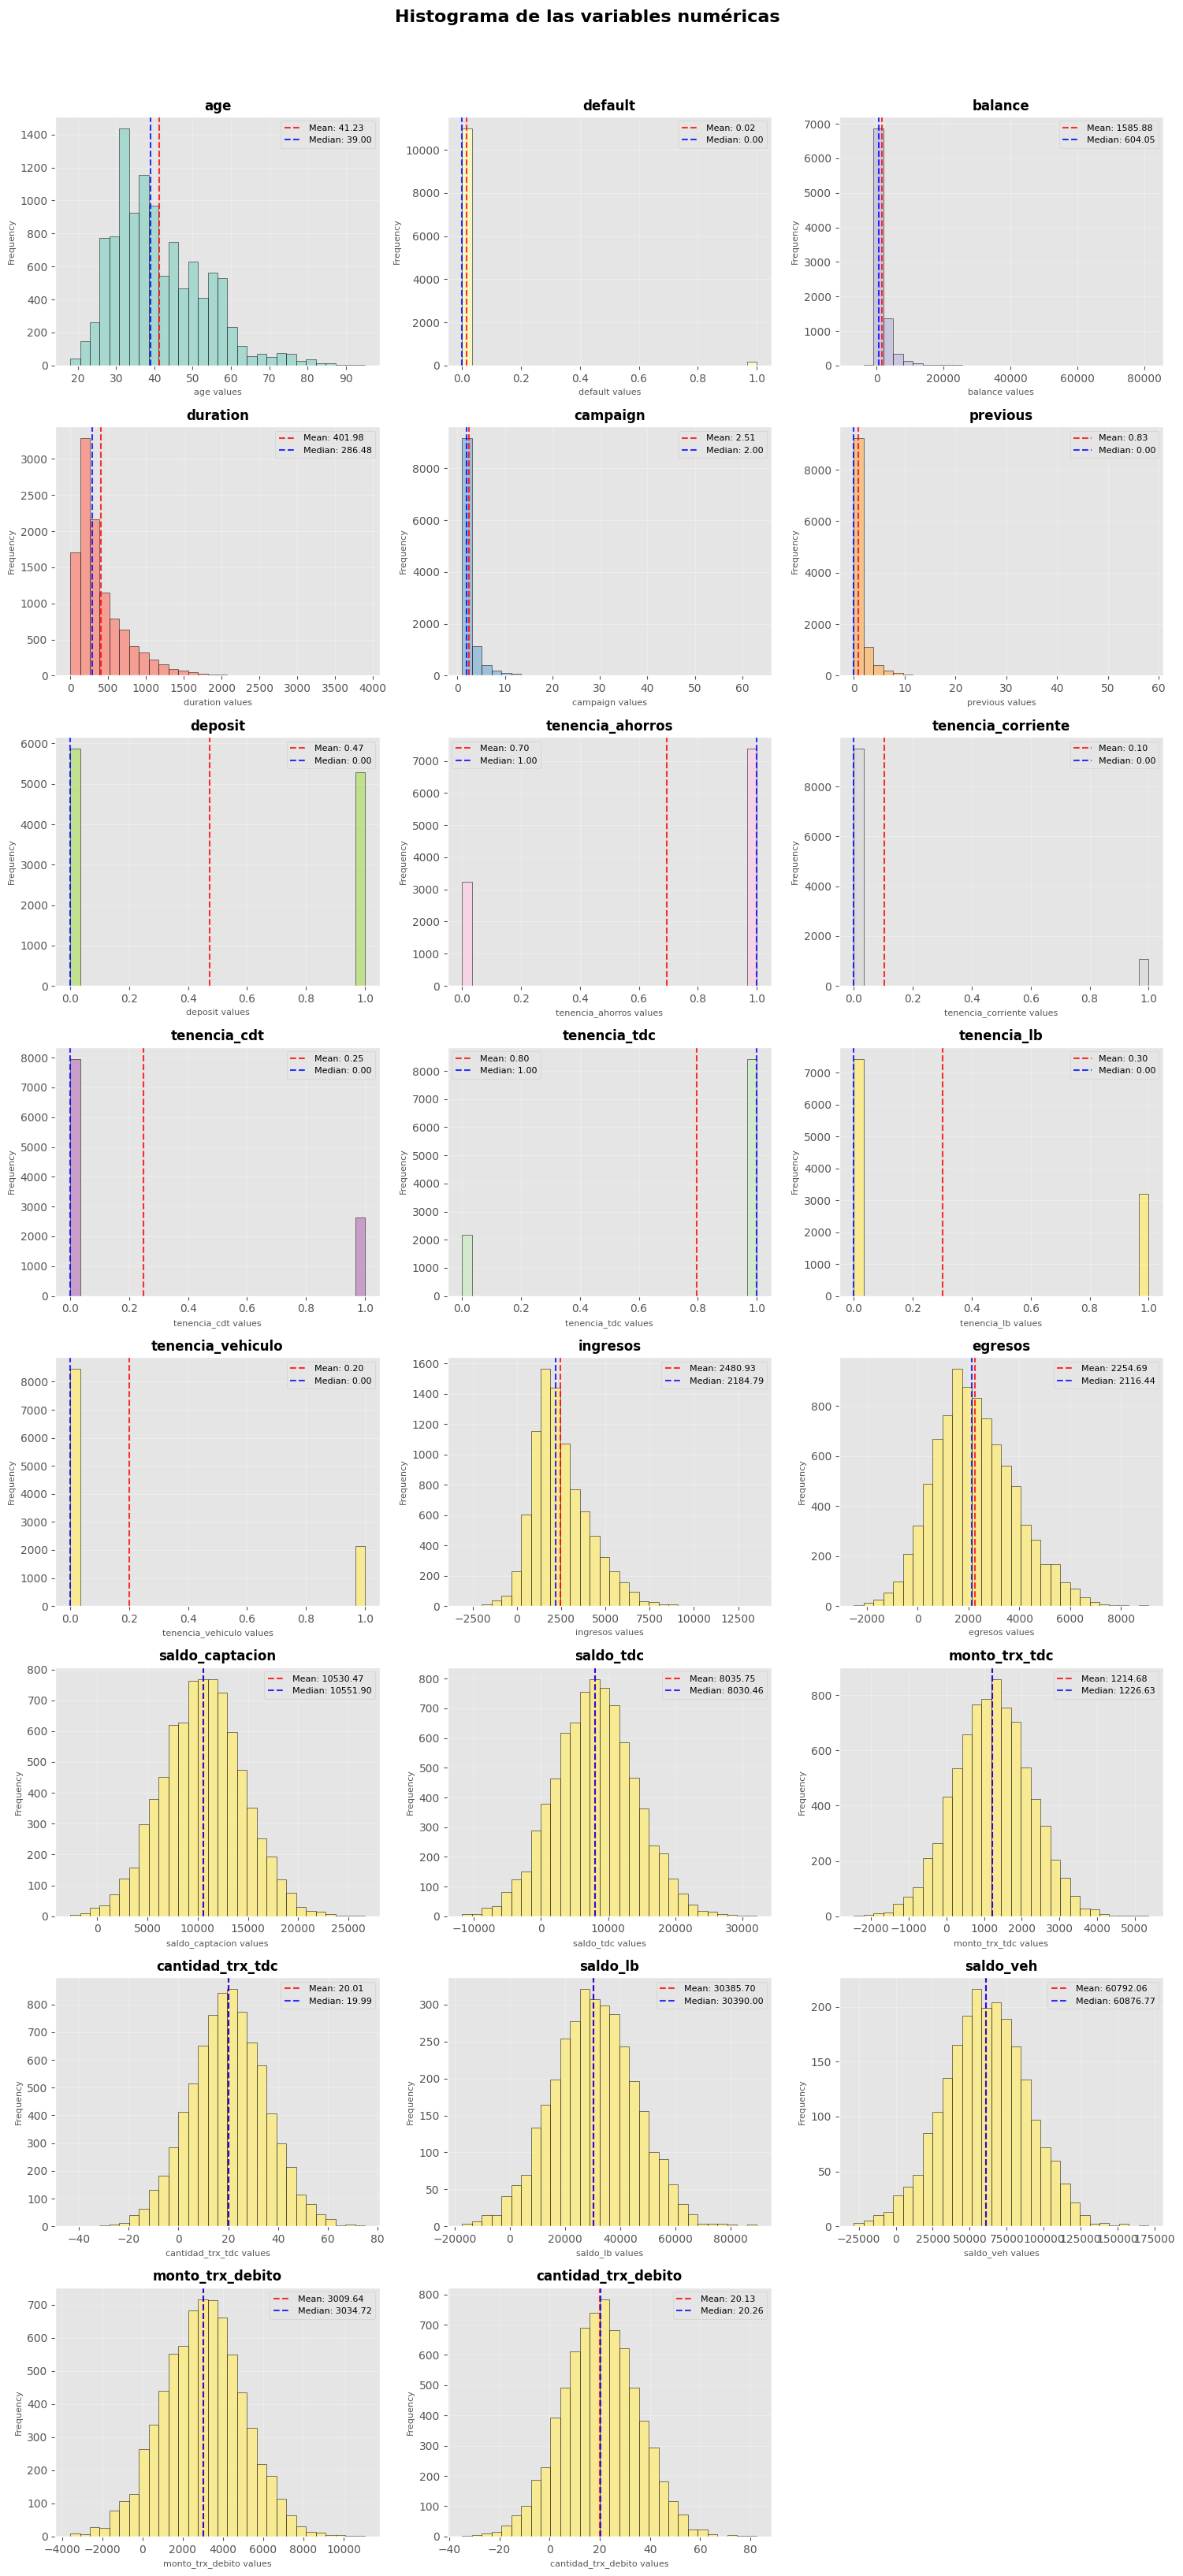

In [17]:
%matplotlib inline
visualize_histograms(Frame=data, column_type='number')

In [18]:
distributed_numeric_cols = [
    'age', 'ingresos', 'egresos', 'saldo_captacion', 'saldo_tdc',
    'monto_trx_tdc', 'cantidad_trx_tdc', 'saldo_lb', 'saldo_veh',
    'monto_trx_debito', 'cantidad_trx_debito'
]

shapiro_results = {}
for variable in distributed_numeric_cols:
    values = data.loc[:, variable].dropna()
    sample_size = min(3000, len(values))  # Limit sample size to 3000 for ensuring test performance
    
    if sample_size < len(values):
        values = values.sample(n=sample_size, random_state = random_state)
        
    statistic, p_value = shapiro(values)
    shapiro_results[variable] = {
        'statistic': statistic, 
        'p_value': p_value, 
        'N': len(values)
    }

# Show the results
pd.DataFrame(shapiro_results).T

,statistic,p_value,N
age,0.949947,7.683479e-31,3000.0
ingresos,0.966801,9.298676e-26,3000.0
egresos,0.992053,8.034380e-12,3000.0
saldo_captacion,0.999427,5.197926e-01,3000.0
saldo_tdc,0.999572,7.887617e-01,3000.0
monto_trx_tdc,0.999578,7.981802e-01,3000.0
cantidad_trx_tdc,0.999544,7.376017e-01,3000.0
saldo_lb,0.999412,4.929762e-01,3000.0
saldo_veh,0.999439,7.817861e-01,2238.0
monto_trx_debito,0.999215,2.225780e-01,3000.0


Usando el test de Shapiro-Wilk, observarmos que hay evidencia estadística de que las variables `saldo_captacion`, `saldo_tdc`, `monto_trx_tdc`, `cantidad_trx_tdc`, `saldo_lb`, `saldo_veh`, `monto_trx_debito`, `cantidad_trx_debito` pueden ser modeladas con un diustribución normal. Mencionar los insgihts de las variables categóricas de acuerdo al análisis de su distribución y comportamiento.

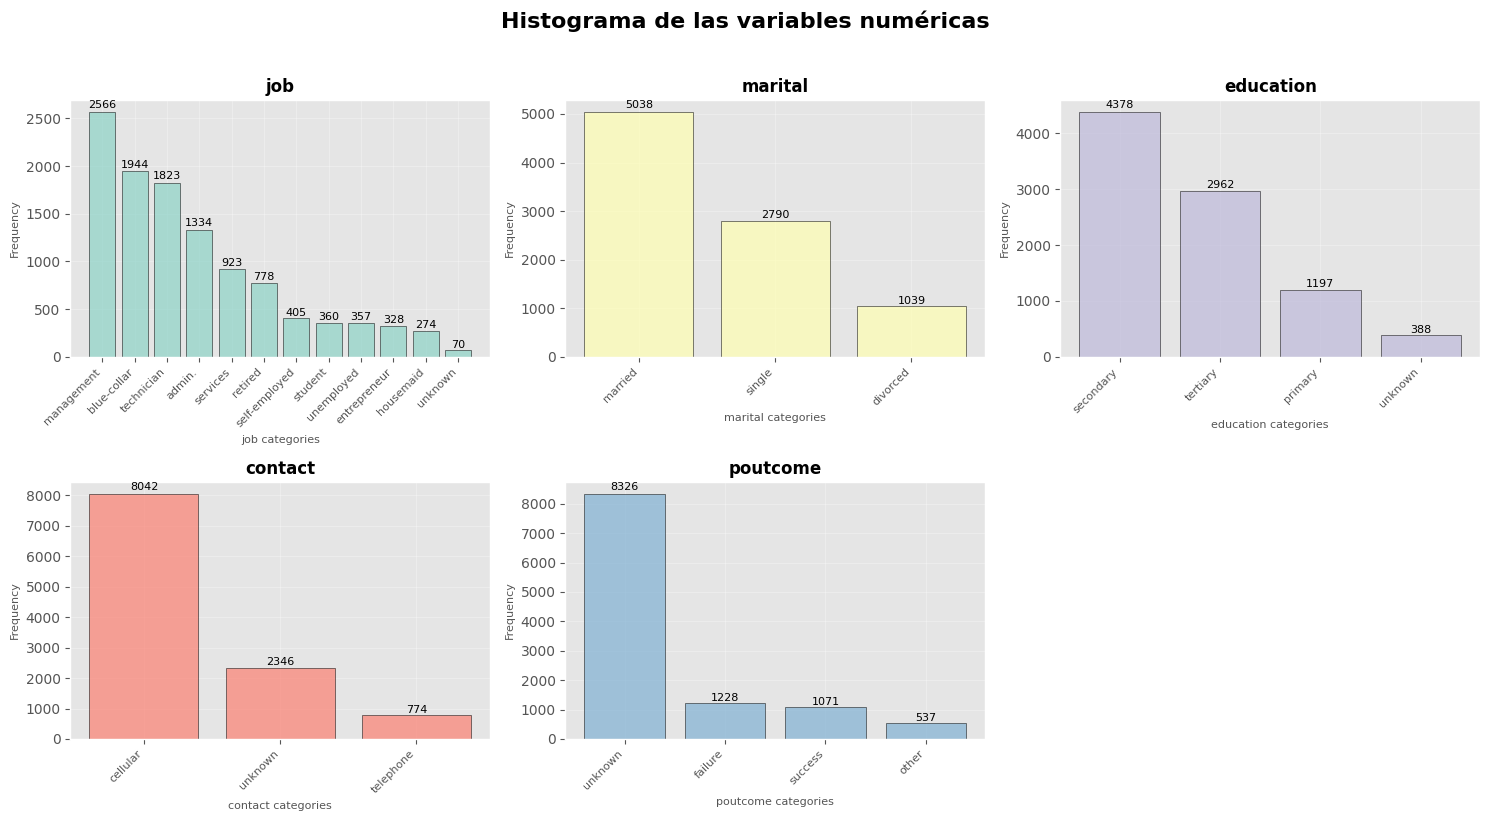

In [19]:
%matplotlib inline
visualize_histograms(Frame=data, column_type='object')

Vamos a excluir las variables `contact` y `putoutcome`, ya que nos sirven más para entender la lógica de negocio suyacente y no tanto para identificar patrones en los datos. La podemos usar más adelnante para determinar cuál es el grupo de personas que adquirieron un producto gracias a una _campaña publicitaria_ además de determinar cuál fue el método usado para este propósito. Por otro lado, entender MAR, MCAR, y MNAR es bueno para justificar el tipo de imputación u otra en las variable sesgada `balance` antes de aplicar la transformación Yeo-Johnson para corregir la asimetría de la distribución de los datos. Finalmente, como hemos visto anteriormente, las variables `ingresos` y `egresos` están altamente correlacionadas, por lo que vamos a eliminar una de ellas. En este caso, vamos a eliminar `egresos` y a quedarnos con `ingresos`, ya que es más representativa de la capacidad de pago del cliente.

In [20]:
# We extract the 'contact' and 'poutcome' columns for further analysis
_data = data.loc[:, ['contact', 'poutcome']].copy()

data_contacted = pd.merge(
    data_contacted, _data, left_index=True, right_index=True, how='left'
)

data = data.drop(columns=['contact', 'poutcome'], axis=1)

# We extreact the 'egresos' column for further analysis
data = data.drop(columns=['egresos'], axis=1)

In [21]:
params_dist = {
  'impute_knn_numeric__transformer__n_neighbors': [3, 5, 7, 9],
  'impute_knn_numeric__transformer__weights': ['uniform', 'distance']
}

education_label_encoding = {
    'primary': 1,
    'secondary': 2, 
    'tertiary': 3,
    'unknown': 0
}

featPipe = Pipeline([
    ('drop_duplicate_features', DropDuplicateFeatures()),
    ('impute_categorical_features', CategoricalImputer(variables = ['job', 'marital', 'education'], imputation_method = 'frequent')),
    ('transform_education_mapper', StringDictionaryMapper(mapping_dict = education_label_encoding, columns = ['education'], handle_missing = 'ignore')),
    ('transform_categorical_onehot', OneHotEncoder(variables = ['marital'], drop_last = True)),
    ('impute_categorical_frequency', CountFrequencyEncoder(variables = ['job'], encoding_method= 'frequency')),
    ('impute_balance_feature', MeanMedianImputer(variables = ['balance'], imputation_method= 'median')),
    ('transform_balance_feature', EqualFrequencyDiscretiser(variables = ['balance'], return_object = False)),
    ('transform_skewed_features', YeoJohnsonTransformer(variables = ['duration', 'campaign', 'previous'])),
    ('transform_standarize_numeric', SklearnTransformerWrapper(
        transformer = StandardScaler(), 
        variables = ['age', 'education', 'duration', 'ingresos', 'saldo_captacion', 'saldo_tdc', 'monto_trx_tdc', 'cantidad_trx_tdc', 'saldo_lb', 'saldo_veh', 'monto_trx_debito', 'cantidad_trx_debito']
    )),
    ('impute_knn_numeric', SklearnTransformerWrapper(
        transformer = KNNImputer(n_neighbors=5, weights='distance', metric='nan_euclidean'),
        variables = ['age', 'job', 'education', 'balance', 'duration', 'campaign', 'previous', 'ingresos', 'saldo_captacion', 'saldo_tdc', 'monto_trx_tdc', 'cantidad_trx_tdc', 'saldo_lb', 'saldo_veh', 'monto_trx_debito', 'cantidad_trx_debito']
    )),
])

pipeSearch = RandomizedSearchCV(
    estimator = featPipe,
    param_distributions = params_dist,
    n_iter = 8,
    cv = 5,
    scoring = make_scorer(davies_bouldin_score, greater_is_better = False),
    verbose = 3,
    n_jobs = -1,
    random_state = random_state,
    return_train_score = True,
)

pipeSearch.fit(data)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('drop_duplicate_features',
                                              DropDuplicateFeatures()),
                                             ('impute_categorical_features',
                                              CategoricalImputer(imputation_method='frequent',
                                                                 variables=['job',
                                                                            'marital',
                                                                            'education'])),
                                             ('transform_education_mapper',
                                              StringDictionaryMapper(columns=['education'],
                                                                     mapping_dict={'primary': 1,
                                                                                   'secondary': 2,
                                                                                   'tertiary': 3...
                                                                                   'monto_trx_debito',
                                                                                   'cantidad_trx_debito']))]),
                   n_iter=8, n_jobs=-1,
                   param_distributions={'impute_knn_numeric__transformer__n_neighbors': [3,
                                                                                         5,
                                                                                         7,
                                                                                         9],
                                        'impute_knn_numeric__transformer__weights': ['uniform',
                                                                                     'distance']},
                   random_state=11, return_train_score=True,
                   scoring=make_scorer(davies_bouldin_score, greater_is_better=False, response_method='predict'),
                   verbose=3)

In [22]:
print('<---- Basic data description ---->')
print('Best parameters found:')
display(pipeSearch.best_params_)

bestPipe = pipeSearch.best_estimator_

data_processed = bestPipe.transform(data)
data_processed = data_processed[~data_processed[[
    'tenencia_ahorros', 'tenencia_corriente', 'tenencia_cdt', 'tenencia_tdc', 'tenencia_lb', 'tenencia_vehiculo'
]].isna().any(axis = 1)]

<---- Basic data description ---->
Best parameters found:


{'impute_knn_numeric__transformer__weights': 'uniform',
 'impute_knn_numeric__transformer__n_neighbors': 3}

In [23]:
prunePipe = Pipeline([
    ('drop_correlated_features', DropCorrelatedFeatures(variables=None, method='pearson', threshold=0.80)),
    ('drop_constant_features', DropConstantFeatures(tol=0.85)),
])

prunePipe.fit(data_processed)

print('<---- Basic data description ---->')
print('Columns removed by pruning pipeline:')
print(set(data_processed.columns) - set(prunePipe.transform(data_processed).columns))

# Now we define the puruned features using the pruning pipeline
data_processed_pruned = prunePipe.transform(data_processed)

<---- Basic data description ---->
Columns removed by pruning pipeline:
{'default', 'tenencia_corriente'}


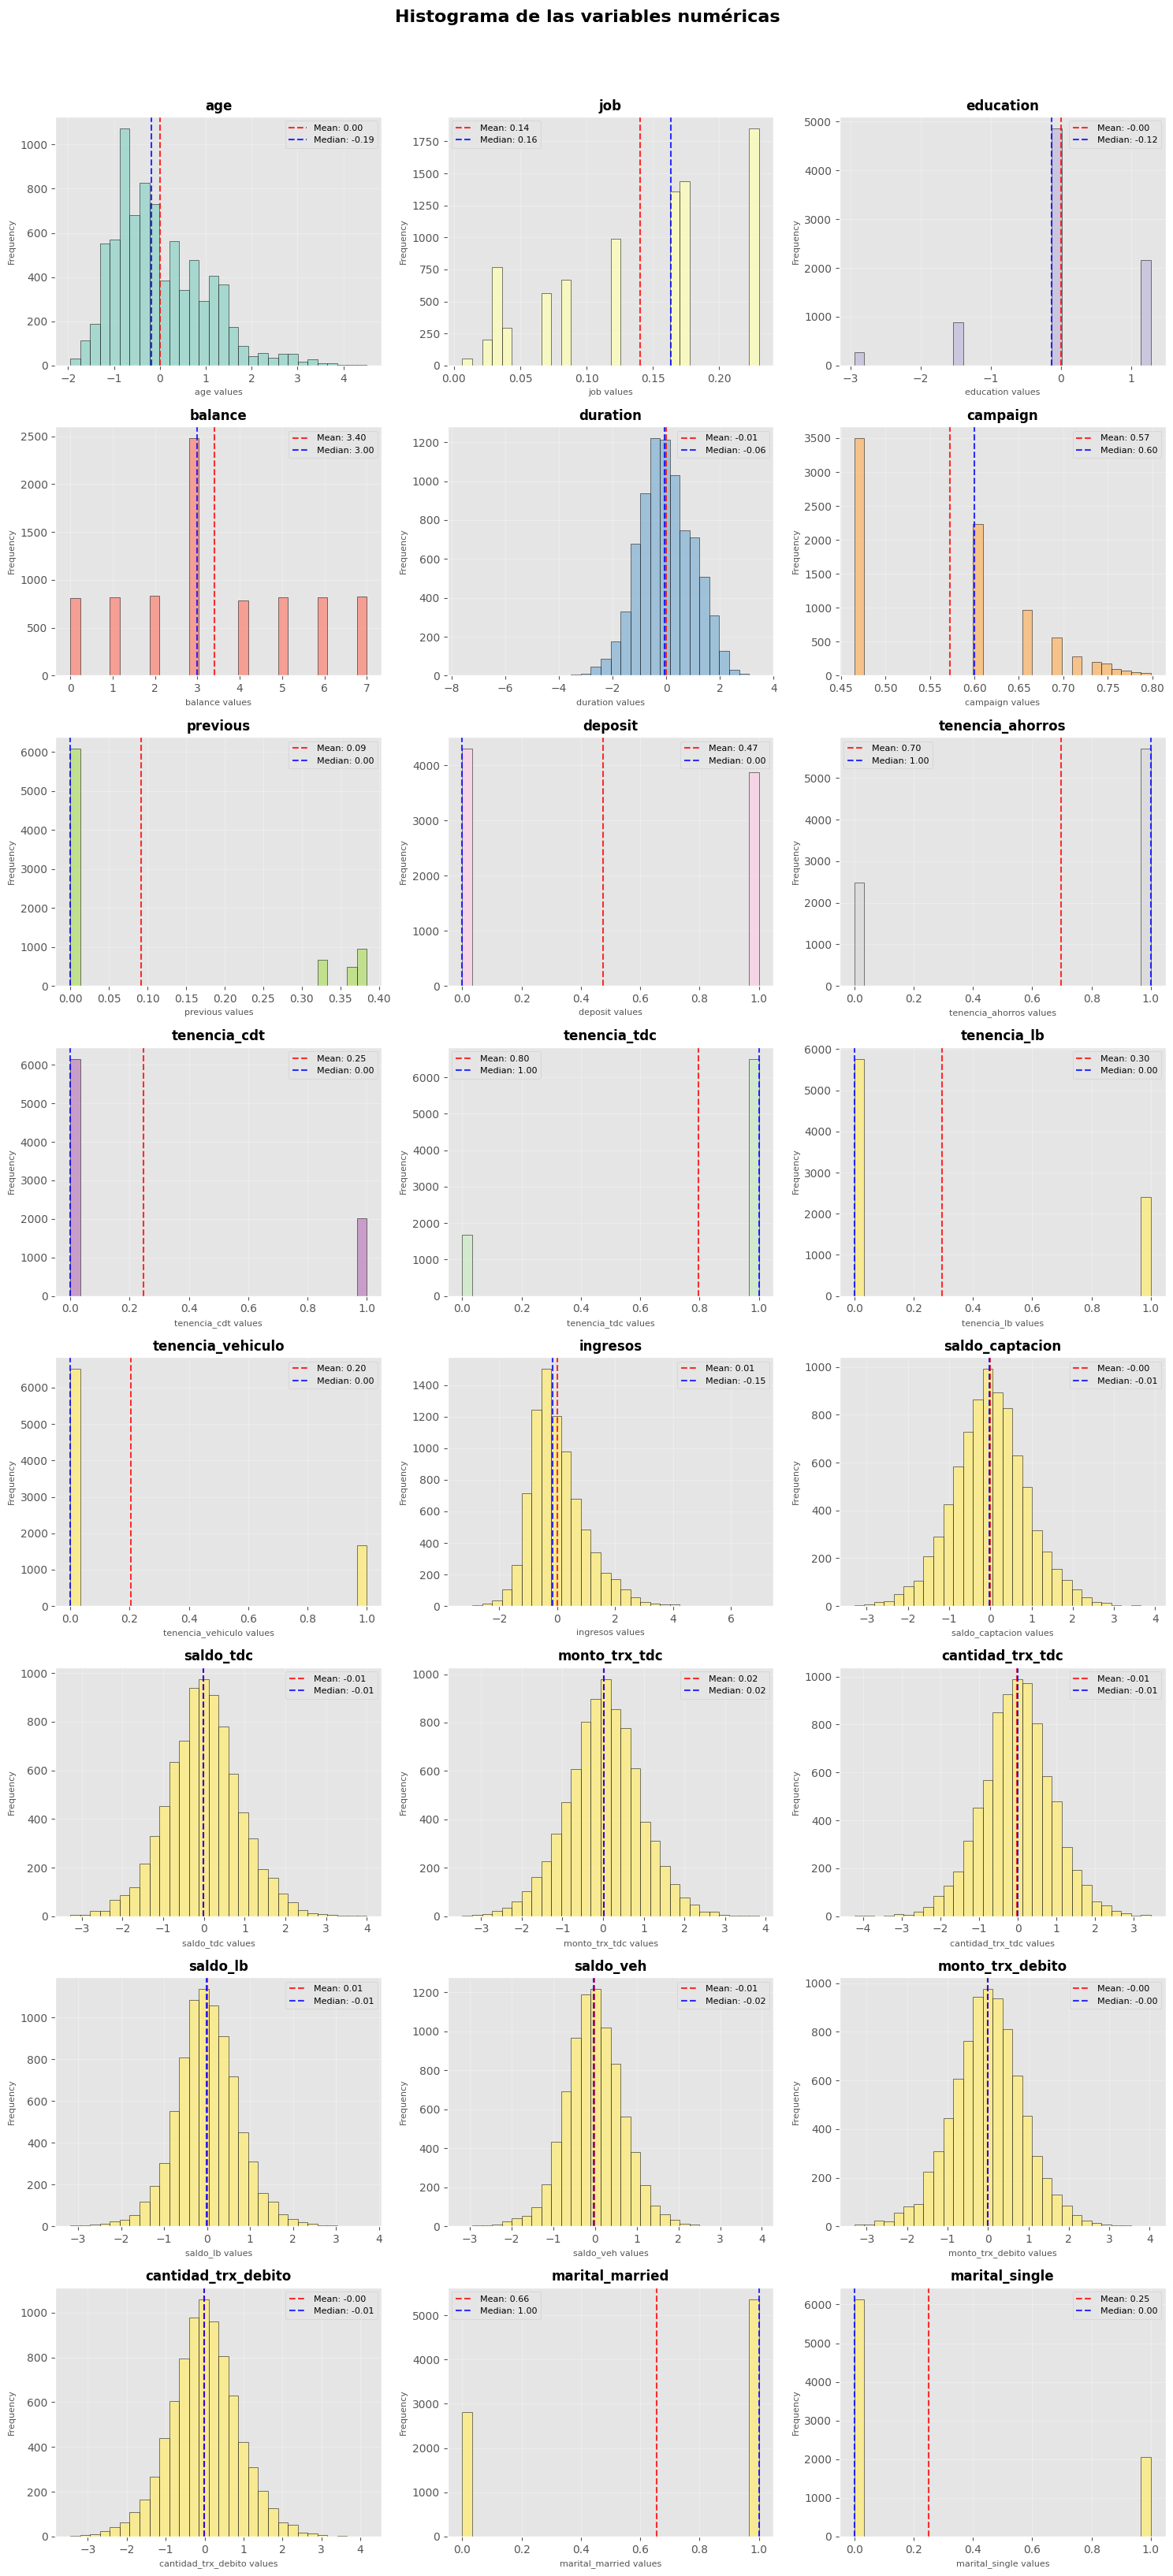

In [24]:
%matplotlib inline
visualize_histograms(Frame=data_processed_pruned, column_type='number')

# We can compute the amount of target variable that is lost due to dropping missing values in binary features
# display(data[~data[['tenencia_ahorros', 'tenencia_corriente', 'tenencia_cdt', 'tenencia_tdc', 'tenencia_lb', 'tenencia_vehiculo']].isna().any(axis=1)].merge(
#     data_target.target, 
#     left_index=True, right_index=True, how='left'
# ).target.value_counts())

# display(data[data[['tenencia_ahorros', 'tenencia_corriente', 'tenencia_cdt', 'tenencia_tdc', 'tenencia_lb', 'tenencia_vehiculo']].isna().any(axis=1)].merge(
#     data_target.target, 
#     left_index=True, right_index=True, how='left'
# ).target.value_counts())

In [25]:
# Saving data to a new Excel file in the staging directory
data_processed_pruned.to_excel(os.path.join(data_dir, 'staging', '02_data_prueba_ds_loan_housing_eda_imputation_prune.xlsx'), index=True, engine='openpyxl')
data_contacted.to_excel(os.path.join(data_dir, 'staging', '02_data_prueba_ds_loan_housing_contacted.xlsx'), index=True, engine='openpyxl')
data_target.to_excel(os.path.join(data_dir, 'staging', '02_data_prueba_ds_loan_housing_target.xlsx'), index=True, engine='openpyxl')

In [26]:
save_model(model=bestPipe, path=os.path.join(parent_dir, 'models', '02_bestPipe.pkl'))
save_model(model=prunePipe, path=os.path.join(parent_dir, 'models', '02_prunePipe.pkl'))

Object 02_bestPipe.pkl saved successfully! ✌🏾
Object 02_prunePipe.pkl saved successfully! ✌🏾
